# Unsupervised Feature Learning

Supervised approaches for classification are common, and their results are usually very satisfying. However, when dealing with unlabeled data, it's hard to extract the features.
We plan to put the unlabeled images into neural networks, for example, ConvNets and autoencoder. Then aggregate the hypercolumn of each pixel in the layers. Finally, apply clustering methods like KMeans for segmentation.

difference between flux and magnittude (people's eyes)
redshift/unsupervised learning 
predict redshift on 
## Data preparation

In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
def nanomaggie_to_luptitude(array, band):
    b = {
        'u': 1.4e-10,
        'g': 0.9e-10,
        'r': 1.2e-10,
        'i': 1.8e-10,
        'z': 7.4e-10
    }
    nanomaggie = array * 1.0e-9
    luptitude = -2.5 / np.log(10) * (np.arcsinh((nanomaggie / (2 * b[band]))) + np.log(b[band]))
    return luptitude

def scale(x):
    result = x - x.mean()
    result = (x - x.min()) / (x.max() - x.min())
    return result

def load_image(filenames, bands, size):
    train_img = []
    for f in filenames:
        image_data = fits.getdata(f)
        #print(image_data.shape)
        nrows = image_data.shape[0] // size - 1
        ncols = image_data.shape[1] // size - 1
        num = nrows*ncols
        #print(nrows, ncols)
        row = 0
        col = 0

        for i in range(num-1):
            if i%ncols == 0 and col!=0:
                row += size
                col = 0
            else:
                col += size
                
            #print(row, col,i)
            img = image_data[row:row+size, col:col+size]
            x = []
            for idx, band in enumerate(bands):
                x_band = nanomaggie_to_luptitude(img, band)
                x_band = scale(x_band)
                x.append(x_band)
            x = np.dstack(x)
            
            if x[:,:,1].var()<0.01:
                train_img.append(x)
    train_img = np.array(train_img)
    return train_img

(1489, 2048)
(1505, 64, 64, 3)


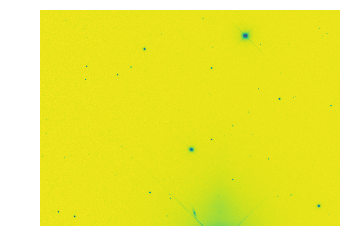

In [3]:
# images for training
frames = [
    "../../data/sdss/frames/frame-g-000109-2-0037.registered.fits", 
    "../../data/sdss/frames/frame-g-000109-4-0143.registered.fits", 
    "../../data/sdss/frames/frame-g-000109-4-0153.registered.fits",
    "../../data/sdss/frames/frame-g-000109-4-0161.registered.fits",
    "../../data/sdss/frames/frame-g-000109-6-0113.registered.fits",
    "../../data/sdss/frames/frame-g-000109-6-0137.registered.fits",
    "../../data/sdss/frames/frame-g-000109-6-0139.registered.fits",
    "../../data/sdss/frames/frame-g-002589-4-0298.registered.fits",
    "../../data/sdss/frames/frame-i-000109-2-0037.registered.fits",
]

img1 = fits.getdata(frames[0])
img1_r = nanomaggie_to_luptitude(img1, 'r')
print(img1_r.shape)
plt.imshow(img1_r)
plt.axis('off')

train_img = load_image(filenames=frames, bands="gri", size=64)
print(train_img.shape)
nimg = train_img.shape[0]

segment the large original fits file(1489x2048) into small pixel images(64x64)

since the pixels of galaxy outweight the pixels of star, many images don't contain any star, so I filter out those images according to the variance of their values.

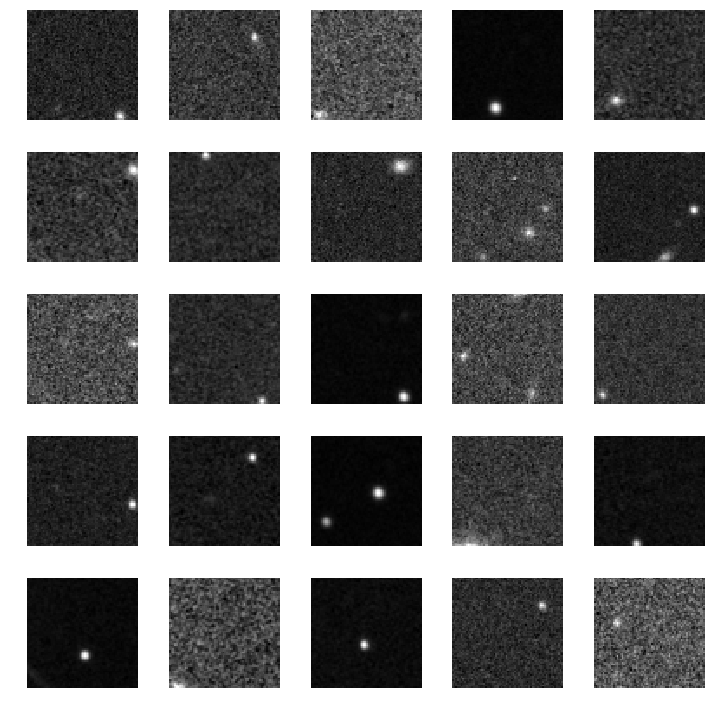

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        ax[i, j].imshow(1 -train_img[idx, :,:,2], cmap='gray')
        ax[i, j].set_axis_off()
        
plt.tight_layout()

In [5]:
for i in range(25):
    print(train_img[i, :,:,1].mean(), train_img[i, :,:,2].var())

0.846162138647 0.00394435610917
0.774648951449 0.00515240591686
0.681526239169 0.00841931711853
0.956336038875 0.00404026299342
0.81300235175 0.00438611236103
0.788842222877 0.00642316550059
0.831544975469 0.00302852387675
0.826509668038 0.00625707725594
0.749716599817 0.00652184452435
0.856823618345 0.00394930718157
0.699973726278 0.0078129006885
0.827163048007 0.0026594439607
0.95376592236 0.00319218891638
0.721649741701 0.00746765722483
0.788821398173 0.0031014693666
0.867874764862 0.00285148254203
0.899264095457 0.00256732156952
0.956508315104 0.00478086108389
0.766200091939 0.00605670721911
0.925557227706 0.00192905531191
0.940934230782 0.00271243357713
0.726960511437 0.00877773919168
0.93772692488 0.00236947625241
0.820736087823 0.00344705479226
0.664269599806 0.00985062554887


#### Autoencoder

In [5]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda
from keras.models import Sequential
from keras.optimizers import SGD, Adadelta, Adagrad,Adam, rmsprop
from keras import objectives
from keras.callbacks import TensorBoard
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [7]:
model = Sequential()
original_dim = 64*64
latent_units = 2  

# encode
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(8*8*2, activation='tanh'))
model.add(Reshape((8, 8, 2)))

# decode
#model.add(Dense(512, activation='tanh'))
#model.add(Dense(8*8*8, activation='relu'))
#model.add(Reshape((8,8,8)))

model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), padding='same',  activation='sigmoid'))

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.binary_crossentropy(x,decoded)
    return xent_loss


model.compile(loss=binary_crossentropy, optimizer='rmsprop', metrics=['accuracy'])

model.fit(train_img[:1400], train_img[:1400], 
          epochs=30,
          shuffle=True,
         )

Epoch 1/30
1400/1400 [==============================] - 7s - loss: 0.4991 - acc: 2.4548e-04     
Epoch 2/30
1400/1400 [==============================] - 7s - loss: 0.4687 - acc: 2.4414e-04     
Epoch 3/30
1216/1400 [=========================>....] - ETA: 1s - loss: 0.4573 - acc: 2.4414e-04

KeyboardInterrupt: 

### VAE

In [11]:
latent_units = 2  
epsilon_std = 1.0  
original_dim = 64*64
latent_dim = 2

#encoder:
input_img = Input(shape=(64,64,3))

x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

h = Flatten()(x)
encoded = Dense(256, activation='tanh')(h)

#decode
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
def sampling(args): 
    epsilon = K.random_normal(shape=(32, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

h2 = Dense(256,activation='tanh')(z)#for VAE
h3 = Dense(8*8*8,activation='relu')(h2)
h4 = Reshape((8,8,8))(h3)

x = Conv2D(8, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h4)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

vae = Model(inputs=input_img, outputs=decoded) 
vae.compile(optimizer='rmsprop', loss=vae_loss, metrics=['accuracy'])
    
vae.fit(train_img, train_img,  
            shuffle=True,
            epochs=30,  
       )

Epoch 1/30
1505/1505 [==============================] - 8s - loss: 8085.7997 - acc: 0.0300     
Epoch 2/30
1505/1505 [==============================] - 8s - loss: 2098.3267 - acc: 0.7261     
Epoch 3/30
1505/1505 [==============================] - 8s - loss: 2003.3440 - acc: 0.6912     
Epoch 4/30
1505/1505 [==============================] - 8s - loss: 1972.1592 - acc: 0.7616     
Epoch 5/30
1505/1505 [==============================] - 8s - loss: 1939.9678 - acc: 0.7595     
Epoch 6/30
1505/1505 [==============================] - 8s - loss: 1918.3555 - acc: 0.7650     
Epoch 7/30
1505/1505 [==============================] - 8s - loss: 1919.0276 - acc: 0.7977     
Epoch 8/30
1505/1505 [==============================] - 8s - loss: 1905.4779 - acc: 0.8033     
Epoch 9/30
1505/1505 [==============================] - 8s - loss: 1911.7908 - acc: 0.8322     
Epoch 10/30
1505/1505 [==============================] - 8s - loss: 1899.0785 - acc: 0.8453     
Epoch 11/30
1505/1505 [================

In [70]:
model = vae

def get_layer_outputs(test_img):
    outputs    = [layer.output for layer in model.layers]          # all layer outputs
    comp_graph = [K.function([model.input]+ [K.learning_phase()], [output]) for output in outputs]  # evaluation functions

    # Testing
    layer_outputs_list = [op([test_img, 1.]) for op in comp_graph]
    layer_outputs = []

    for layer_output in layer_outputs_list:
        #print(layer_output[0][0].shape, end='\n-------------------\n')
        layer_outputs.append(layer_output[0][0])

    return layer_outputs

layers = get_layer_outputs([train_img[0, : , : , :]])
print(layers[8])

[ 2.53774118  0.09324489]


It shows the structure of all the layers of AE/VAE. 
Then I resize each layer to the same size of the input layer(64x64) in order to extract the hypercolumns

In [115]:
from skimage.transform.pyramids import pyramid_expand
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=2, compute_labels=False)

hypercolumns = []
x_encoder_test1 = []
x_encoder_test2 = []
for img_idx in range(64):
    #print(img_idx)
    layers = get_layer_outputs([train_img[img_idx, : , : , :]])
    l = []
    for idx in range(7):
        layer = layers[idx]
        layer = scale(layer)
        
        if idx in [0,1]:
            l.append(layer)
        if idx in [2, 3]:
            l.append(pyramid_expand(layer, upscale=2))
        if idx in [4, 5]:
            l.append(pyramid_expand(layer, upscale=4))
        if idx in [6]:
            l.append(pyramid_expand(layer, upscale=8))
    
    l = np.dstack(l)
    #print(l)
    x_encoder_test1.append(layers[8])
    #x_encoder_test2.append(pyramid_expand(layers[8], upscale=8)) 

    #hypercolumns.append(l)
    
    for i in range(64):
        for j in range(64):
            hypercolumns.append(l[i,j,:])
            
    x_encoder_test = np.row_stack(x_encoder_test1)

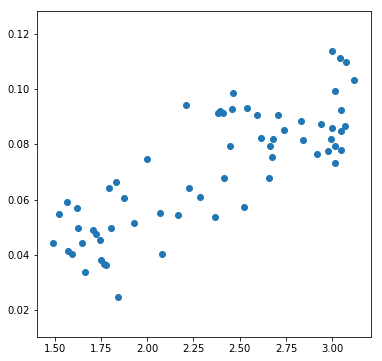

In [118]:
#print(x_encoder_test)

plt.figure(figsize=(6, 6))
plt.scatter(x_encoder_test[:, 0] ,x_encoder_test[:, 1], c=label_value[8000:9000])
#plt.colorbar()
plt.show()


It shows that the two hidden units of the encoded layer are linear related. Try to associate this phenomenom with the background knowledge.

## Result

Aggregate the hypercolumns of each pixel (64x64 hypercolumn for each image), then apply K-Means clustering with 2 classes.

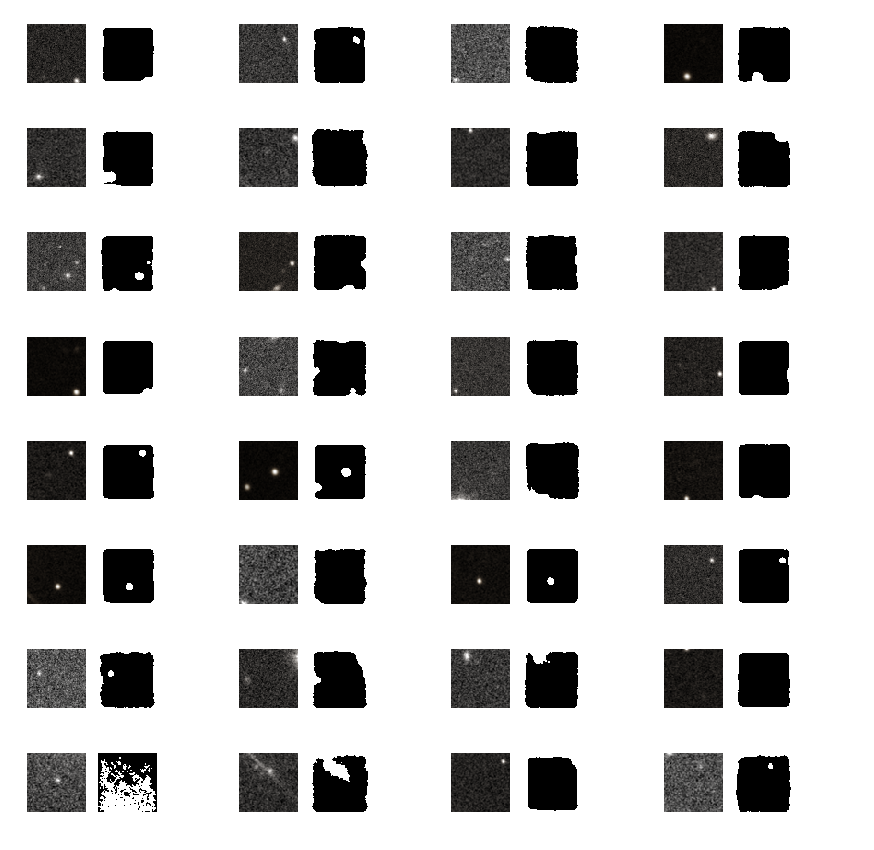

In [120]:
kmeans = MiniBatchKMeans(n_clusters=2, compute_labels=False)
fig, ax = plt.subplots(nrows=8, ncols=12, figsize=(15, 15))

for i in range(8):
    for j in range(4):
        idx = 4*i+j
        patch = train_img[idx]
        ax[i, 3*j].imshow(1 - patch)
        ax[i, 3*j].axis('off')       
        
        aggregate_hpcol = hypercolumns[idx*64*64:(1+idx)*64*64]
        kmeans.fit(aggregate_hpcol)
        patch_label = kmeans.predict(aggregate_hpcol).reshape((64,64))
        if patch_label.mean() < 0.5:
            patch_label = 1-patch_label
        ax[i, 3*j+1].imshow(1-patch_label, cmap = 'gray')
        ax[i, 3*j+1].axis('off')
        ax[i, 3*j+2].axis('off')
    

It seems that this model can do the classification roughly, but it still has difficulty dealing with faint stars or blurry background.
I did the clustering on each images independently, and I also did clustering on all pixels as a whole, the result becomes worse.Because the pixel distribution of each images are quite different, some images are clear, however some are blurry. We can't just simply aggregate them together to do the classification.
## TODO
#### 1. this model works fine only on clear images, so maybe we can do more data preparation to create better training samples
#### 2. optimize the AE/VAE model
#### 3. try to explain the phenomenom （maybe each hidden feature of the encoder represent certain physical property?)
#### 4. the value of k in K-Means

---

# FROM RJB

You might search for the highest pixel and ensure it is near the center of your image.

----